### notebook purpose

general evaluation

In [1]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import torch

sys.path.insert(0, '../')
from utils.evaluate import plot_row_qdess
from utils.evaluate import calc_metrics_imgs, plot_row_qdess, scale_0_1
from utils.data_io import get_mtr_ids_and, load_imgs, load_qdess
from utils.transform import reshape_adj_channels_to_complex_vals, \
                            reshape_complex_vals_to_adj_channels

In [25]:
accel = 8
path_base = '/bmrNAS/people/dvv/out_qdess/accel_{}x/'.format(accel)

path_gt = path_base + 'gt/'

CALIB = 'max'
path_bl = path_base + 'calib/24/'
path_new = path_base + 'calib/{}/'.format(CALIB)

### load imgs, calc metrics

In [26]:
mtr_id_list = get_mtr_ids_and(path_bl, path_new)

imgs_gt = load_imgs(mtr_id_list, path=path_gt)
imgs_bl = load_imgs(mtr_id_list, path=path_bl)
imgs_new = load_imgs(mtr_id_list, path=path_new)
    
metrics_bl = calc_metrics_imgs(imgs_gt, imgs_bl)
metrics_new = calc_metrics_imgs(imgs_gt, imgs_new)

### avg metrics across all samples

In [27]:
print(mtr_id_list)

mu_bl = np.around(np.mean(metrics_bl, 0), 4)
mu_new = np.around(np.mean(metrics_new, 0), 4)
mu_diff = mu_new - mu_bl
print('\n', mu_bl, '\n', mu_new, '\n\n', mu_diff, '\n', mu_new/mu_bl-1)

['005', '006', '030', '034', '048', '052', '065', '066', '080', '096', '099', '120']

 [[ 0.797   0.9415  0.7734 28.5598]
 [ 0.677   0.9056  0.705  30.5881]] 
 [[ 0.7721  0.9451  0.7921 27.5935]
 [ 0.6892  0.9262  0.7424 30.6956]] 

 [[-0.0249  0.0036  0.0187 -0.9663]
 [ 0.0122  0.0206  0.0374  0.1075]] 
 [[-0.03124216  0.00382369  0.02417895 -0.03383427]
 [ 0.01802068  0.02274735  0.05304965  0.00351444]]


### indiv sample metrics

In [28]:
for idx_s, mtr_id in enumerate(mtr_id_list):
    
    print(mtr_id)
    print(metrics_bl[idx_s])
    print(metrics_new[idx_s])
    sys.exit()

005
[[ 0.7978  0.9442  0.8071 28.7474]
 [ 0.501   0.8776  0.6491 29.183 ]]
[[ 0.7618  0.948   0.7986 27.6738]
 [ 0.5231  0.8955  0.6558 29.4052]]


SystemExit: 

### plot

SystemExit: 

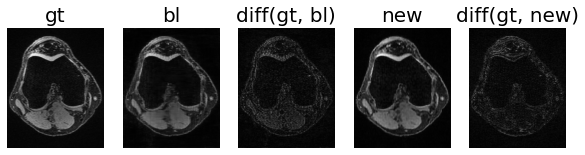

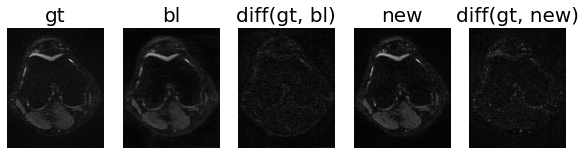

In [31]:
title_list = ['gt', 'bl', 'new']
clim_list = [None] * len(title_list)
DIFF_MAP = False
DIFF_MAP_ALL = True

for idx_s in np.arange(imgs_gt.shape[0]):
    for idx_e in np.arange(imgs_gt.shape[1]):
        
        im_gt, im1, im2 = imgs_gt[idx_s, idx_e], \
                          imgs_bl[idx_s, idx_e], \
                          imgs_new[idx_s, idx_e]
#         im_gt, im1, im2 = scale_0_1(im_gt), scale_0_1(im1), scale_0_1(im2)
        arr_list = [im_gt, im1, im2]
        
        if DIFF_MAP:
            C = 4 # constant for plotting on clim=(0,1)
            im_diff = C * np.abs(scale_0_1(im1) - scale_0_1(im2))
#             im_diff = C * np.abs(scale_0_1(im2) - scale_0_1(im_gt))
            arr_list.append(im_diff)
            title_list.append('diff')
            clim_list.append((0,1))
    
        if DIFF_MAP_ALL: # plot all diffs
            C = 2
            title_list = ['gt', 'bl', 'diff(gt, bl)', 'new', \
                          'diff(gt, new)']
            arr_list[2] = C * np.abs(scale_0_1(im1) - scale_0_1(im_gt))
            arr_list.append(im2)
            arr_list.append(C * np.abs(scale_0_1(im2) - scale_0_1(im_gt)))
            clim_list = [None, None, (0,1), None, (0,1)]
            
            
                
        plot_row_qdess(arr_list, title_list, clim_list)
        
    sys.exit()